In [72]:
# Importez les modules nécessaires
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import floor
from pyspark.sql.functions import count
from pyspark.sql.functions import year
from pyspark.sql.functions import datediff
from pyspark.sql.functions import countDistinct


In [11]:
# Créez une session Spark
spark = SparkSession.builder \
    .appName("Nettoyage de données olympiques") \
    .getOrCreate()

In [14]:
# Chargez les données dans un DataFrame Spark
hosts_df = spark.read.csv("hdfs://namenode:9000/data/staging/olympic_hosts.csv", header=True, inferSchema=True)

In [19]:
hosts_df.show(5, truncate=False)

+----------------+-------------------+-------------------+------------------+----------------+-----------+---------+
|game_slug       |game_end_date      |game_start_date    |game_location     |game_name       |game_season|game_year|
+----------------+-------------------+-------------------+------------------+----------------+-----------+---------+
|beijing-2022    |2022-02-20 12:00:00|2022-02-04 15:00:00|China             |Beijing 2022    |Winter     |2022     |
|tokyo-2020      |2021-08-08 14:00:00|2021-07-23 11:00:00|Japan             |Tokyo 2020      |Summer     |2020     |
|pyeongchang-2018|2018-02-25 08:00:00|2018-02-08 23:00:00|Republic of Korea |PyeongChang 2018|Winter     |2018     |
|rio-2016        |2016-08-21 21:00:00|2016-08-05 12:00:00|Brazil            |Rio 2016        |Summer     |2016     |
|sochi-2014      |2014-02-23 16:00:00|2014-02-07 04:00:00|Russian Federation|Sochi 2014      |Winter     |2014     |
+----------------+-------------------+-------------------+------

In [15]:
# Vérifiez les types de données
hosts_df.printSchema()

root
 |-- game_slug: string (nullable = true)
 |-- game_end_date: timestamp (nullable = true)
 |-- game_start_date: timestamp (nullable = true)
 |-- game_location: string (nullable = true)
 |-- game_name: string (nullable = true)
 |-- game_season: string (nullable = true)
 |-- game_year: integer (nullable = true)



In [17]:
# Comptez les valeurs manquantes dans chaque colonne
missing_values = {c: hosts_df.where(col(c).isNull()).count() for c in hosts_df.columns}
print("Valeurs manquantes par colonne : ", missing_values)

Valeurs manquantes par colonne :  {'game_slug': 0, 'game_end_date': 0, 'game_start_date': 0, 'game_location': 0, 'game_name': 0, 'game_season': 0, 'game_year': 0}


In [18]:
# Normalisez les noms de colonnes si nécessaire
# Nous pouvons convertir les noms de colonnes en minuscules
hosts_df = hosts_df.toDF(*(c.lower() for c in hosts_df.columns))

In [19]:
hosts_df.show(5, truncate=False)

+----------------+-------------------+-------------------+------------------+----------------+-----------+---------+
|game_slug       |game_end_date      |game_start_date    |game_location     |game_name       |game_season|game_year|
+----------------+-------------------+-------------------+------------------+----------------+-----------+---------+
|beijing-2022    |2022-02-20 12:00:00|2022-02-04 15:00:00|China             |Beijing 2022    |Winter     |2022     |
|tokyo-2020      |2021-08-08 14:00:00|2021-07-23 11:00:00|Japan             |Tokyo 2020      |Summer     |2020     |
|pyeongchang-2018|2018-02-25 08:00:00|2018-02-08 23:00:00|Republic of Korea |PyeongChang 2018|Winter     |2018     |
|rio-2016        |2016-08-21 21:00:00|2016-08-05 12:00:00|Brazil            |Rio 2016        |Summer     |2016     |
|sochi-2014      |2014-02-23 16:00:00|2014-02-07 04:00:00|Russian Federation|Sochi 2014      |Winter     |2014     |
+----------------+-------------------+-------------------+------

In [44]:
# Vérifier s'il y a des doublons dans le DataFrame
duplicates_df = hosts_df.groupBy(hosts_df.columns).count().where("count > 1")

if duplicates_df.count() > 0:
    print("Il y a des doublons dans le DataFrame.")
    # Supprimer les doublons
    cleaned_df = hosts_df.dropDuplicates()
    print("Doublons supprimés.")
else:
    print("Aucun doublon dans le DataFrame.")
    cleaned_df = hosts_df


Aucun doublon dans le DataFrame.


In [45]:
# Supprimer les lignes contenant des valeurs nulles dans toutes les colonnes
cleaned_df = hosts_df.dropna()

In [46]:

# Supprimer les lignes contenant des valeurs nulles dans une colonne spécifique (par exemple 'game_year')
cleaned_df = hosts_df.dropna(subset=['game_year'])


In [52]:

# Supprimer les lignes contenant des valeurs nulles dans une colonne spécifique (par exemple 'game_year')
cleaned_df = hosts_df.dropna(subset=['game_season'])


In [58]:
# Afficher le DataFrame nettoyé
cleaned_df.show()

+-------------------+-------------------+-------------------+------------------+-------------------+-----------+---------+
|          game_slug|      game_end_date|    game_start_date|     game_location|          game_name|game_season|game_year|
+-------------------+-------------------+-------------------+------------------+-------------------+-----------+---------+
|       beijing-2022|2022-02-20 12:00:00|2022-02-04 15:00:00|             China|       Beijing 2022|     Winter|     2022|
|         tokyo-2020|2021-08-08 14:00:00|2021-07-23 11:00:00|             Japan|         Tokyo 2020|     Summer|     2020|
|   pyeongchang-2018|2018-02-25 08:00:00|2018-02-08 23:00:00| Republic of Korea|   PyeongChang 2018|     Winter|     2018|
|           rio-2016|2016-08-21 21:00:00|2016-08-05 12:00:00|            Brazil|           Rio 2016|     Summer|     2016|
|         sochi-2014|2014-02-23 16:00:00|2014-02-07 04:00:00|Russian Federation|         Sochi 2014|     Winter|     2014|
|        london-

In [54]:
# Chemin où vous souhaitez enregistrer le fichier CSV traité
output_path = "hdfs://namenode:9000/data/staging/output.csv"

In [59]:
#cleaned_df.write.option("header", "true").csv(output_path, mode='overwrite', sep=',')
cleaned_df.write.csv("work/model/olympic_hosts_clean.csv", header=True)

1- Répartition des jeux olympiques par saison 

In [62]:
# Calculer le nombre de jeux olympiques par saison
season_counts = cleaned_df.groupBy('game_season').agg(count('*').alias('count'))

# Afficher la répartition
season_counts.show()

+-----------+-----+
|game_season|count|
+-----------+-----+
|     Summer|   29|
|     Winter|   24|
+-----------+-----+



1-1- Graphique pour la répartition des jeux olympiques par saison

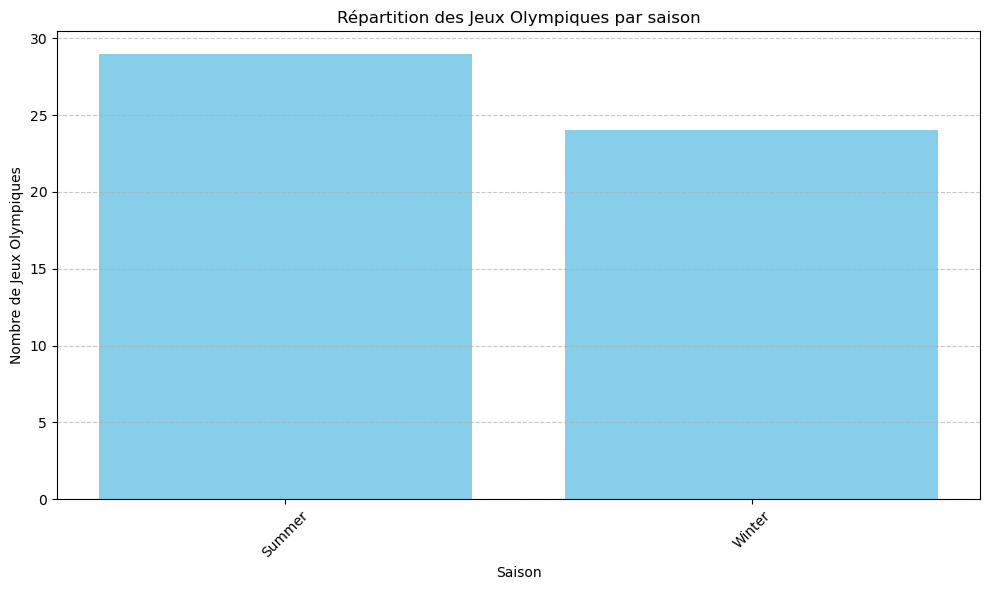

In [75]:
import matplotlib.pyplot as plt

# Extraire les données pour le graphique
season_counts = season_frequency.toPandas()

# Créer le graphique
plt.figure(figsize=(10, 6))
plt.bar(season_counts['game_season'], season_counts['num_occurrences'], color='skyblue')
plt.title('Répartition des Jeux Olympiques par saison')
plt.xlabel('Saison')
plt.ylabel('Nombre de Jeux Olympiques')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


2- Répartition des jeux olympiques par pays hôte 

In [63]:
# Calculer le nombre de jeux olympiques par pays hôte
country_counts = cleaned_df.groupBy('game_location').agg(count('*').alias('count'))

# Afficher la répartition
country_counts.show()

+--------------------+-----+
|       game_location|count|
+--------------------+-----+
|              Sweden|    1|
|   Republic of Korea|    2|
|             Germany|    2|
|              France|    5|
|              Greece|    2|
|             Belgium|    1|
|       Great Britain|    3|
|             Finland|    1|
|               China|    2|
|       United States|    8|
|               Italy|    3|
|              Norway|    2|
|               Spain|    1|
|  Russian Federation|    1|
|Federal Republic ...|    1|
|              Mexico|    1|
|          Yugoslavia|    1|
|         Switzerland|    2|
|              Canada|    3|
|                USSR|    1|
+--------------------+-----+
only showing top 20 rows



3-Tendance temporelle des jeux olympiques 

In [66]:
# Extraire l'année des dates de début des jeux olympiques
year_counts = cleaned_df.withColumn('start_year', year('game_start_date')).groupBy('start_year').agg(count('*').alias('count'))

# Afficher la tendance temporelle
year_counts.show()

+----------+-----+
|start_year|count|
+----------+-----+
|      1896|    1|
|      1924|    2|
|      2018|    1|
|      2006|    1|
|      2022|    1|
|      1908|    1|
|      1952|    2|
|      1956|    2|
|      1988|    2|
|      1994|    1|
|      1968|    2|
|      2014|    1|
|      1904|    1|
|      2004|    1|
|      1932|    2|
|      1996|    1|
|      1998|    1|
|      1960|    2|
|      2012|    1|
|      1912|    1|
+----------+-----+
only showing top 20 rows



4- Analyse des décennies 

In [68]:
# Calculer la décennie pour chaque jeu olympique
cleaned_df = cleaned_df.withColumn('decade', floor(col('game_year') / 10) * 10)

# Répartition des jeux olympiques par décennie et par saison
decade_season_counts = cleaned_df.groupBy('decade', 'game_season').agg(count('*').alias('count'))

# Afficher la répartition
decade_season_counts.show()

+------+-----------+-----+
|decade|game_season|count|
+------+-----------+-----+
|  1930|     Winter|    2|
|  2010|     Summer|    2|
|  1890|     Summer|    1|
|  2020|     Summer|    1|
|  1930|     Summer|    2|
|  1990|     Winter|    3|
|  1990|     Summer|    2|
|  2000|     Summer|    3|
|  2020|     Winter|    1|
|  2000|     Winter|    2|
|  1940|     Summer|    1|
|  2010|     Winter|    3|
|  1960|     Winter|    3|
|  1920|     Winter|    2|
|  1950|     Winter|    2|
|  1980|     Winter|    3|
|  1980|     Summer|    3|
|  1900|     Summer|    3|
|  1920|     Summer|    3|
|  1970|     Winter|    2|
+------+-----------+-----+
only showing top 20 rows



5- Analyse des durées des jeux olympiques 

In [83]:
# Calculer la durée des Jeux Olympiques en jours
cleaned_df = cleaned_df.withColumn('game_duration', datediff('game_end_date', 'game_start_date'))

# Afficher les durées
duration_df.select('game_name', 'duration_days').show()

# Extraire les durées des Jeux Olympiques
game_durations = cleaned_df.select('game_duration').toPandas()


+-------------------+-------------+
|          game_name|duration_days|
+-------------------+-------------+
|       Beijing 2022|           16|
|         Tokyo 2020|           16|
|   PyeongChang 2018|           17|
|           Rio 2016|           16|
|         Sochi 2014|           16|
|        London 2012|           16|
|     Vancouver 2010|           16|
|       Beijing 2008|           16|
|         Turin 2006|           16|
|        Athens 2004|           16|
|Salt Lake City 2002|           16|
|        Sydney 2000|           16|
|        Nagano 1998|           16|
|       Atlanta 1996|           17|
|   Lillehammer 1994|           15|
|     Barcelona 1992|           15|
|   Albertville 1992|           15|
|         Seoul 1988|           16|
|       Calgary 1988|           15|
|   Los Angeles 1984|           15|
+-------------------+-------------+
only showing top 20 rows



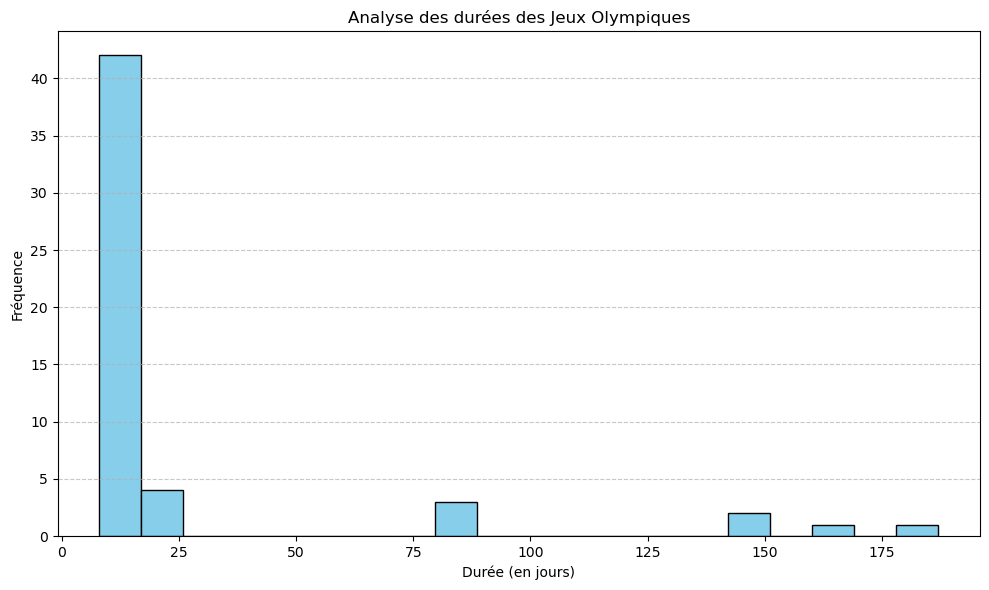

In [84]:
# Créer le graphique
plt.figure(figsize=(10, 6))
plt.hist(game_durations['game_duration'], bins=20, color='skyblue', edgecolor='black')
plt.title('Analyse des durées des Jeux Olympiques')
plt.xlabel('Durée (en jours)')
plt.ylabel('Fréquence')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


6- Analyse de la fréquence des jeux olympiques 

In [74]:
# Calculer la fréquence des jeux olympiques par saison
season_frequency = cleaned_df.groupBy('game_season').agg(countDistinct('game_year').alias('num_occurrences'))

# Calculer la fréquence des jeux olympiques par décennie
decade_frequency = cleaned_df.groupBy('decade').agg(countDistinct('game_year').alias('num_occurrences'))

# Afficher les résultats
season_frequency.show()
decade_frequency.show()


+-----------+---------------+
|game_season|num_occurrences|
+-----------+---------------+
|     Summer|             29|
|     Winter|             24|
+-----------+---------------+

+------+---------------+
|decade|num_occurrences|
+------+---------------+
|  1950|              2|
|  1930|              2|
|  1940|              1|
|  1960|              3|
|  2010|              5|
|  1920|              3|
|  1970|              2|
|  1900|              3|
|  1890|              1|
|  1910|              1|
|  1980|              3|
|  2020|              2|
|  2000|              5|
|  1990|              4|
+------+---------------+

